Following the California Housing Project from the O'REILLY book Hands On Machine Learning with SciKit-Learn, Keras & TensorFlow.

# First Task

Using the California Housing Prices dataset from StatLib our task is to predict the median housing price for a block group.

The dataset includes metrics like population, median income, and median housing price at block group level.

This task lends itself to supervised learning as we have a labelled dataset, and the type of model will be a multiple linear regression, univariate model.

The dataset can be found on kaggle here - https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [1]:
# import our standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotx

In [3]:
# ML Specific Libraries focused on linear regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

In [4]:
# import our data
housing_df = pd.read_csv('../datasets/housing.csv')

In [9]:
# inspect our data
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
# check the value counts for the ocean_proximity column
housing_df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

# Notes on the data

- immediately we realise that there is a non-numeric feature - ocean proximity - which is categorical, we will need to explore how to deal with this data and its effect on our modelling.
- median_income seems to be scaled and capped at 15.000 - our understanding is that 1 = 1000. We will need to consider this carefully when going through feature selection and data transformations/scaling.
- median_house_value looks to be capped at 500001, this is a possible problem as it is the target value. How do we ensure the model does not restrict itself to this cap?
- households and population look like there may be some outliers to consider.
- total_bedrooms has null values which we will need to either fill or remove from the dataset

# Visualise the data

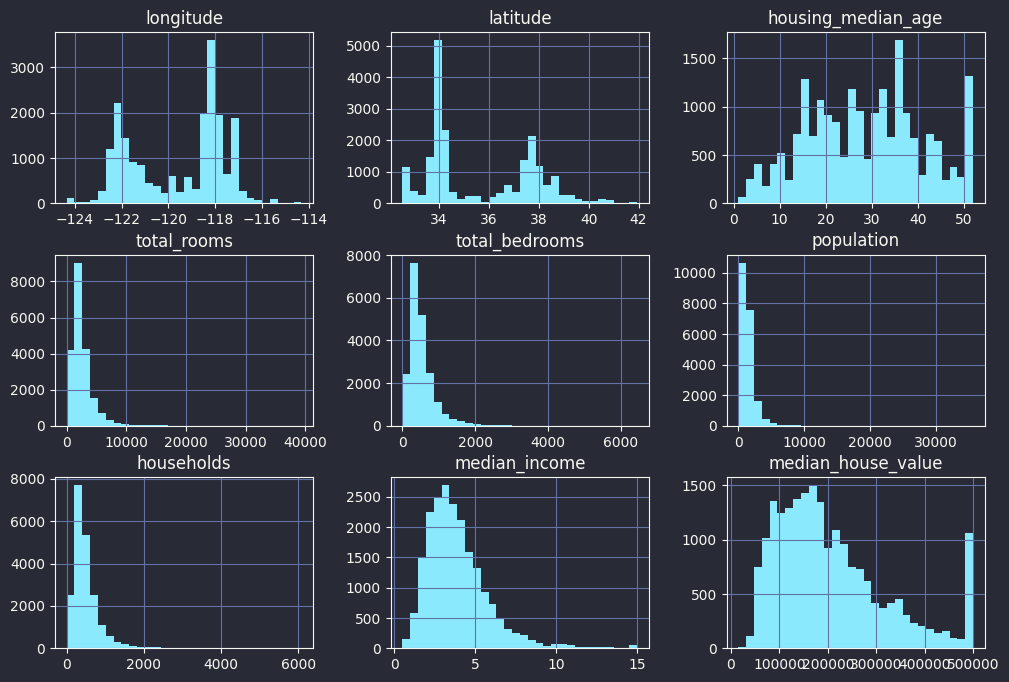

In [7]:
# use everywhere:
plt.style.use(matplotx.styles.dracula)
# plot histograms for each numeric column
housing_df.hist(bins=30, figsize=(12,8))
plt.show()

# Split the data

When splitting the data, we want to ensure there is no sampling bias, therefore, we will use stratified sampling to ensure the spread of data is representative across an important metric. For this dataset, median_income is likely a very important feature and we will categorise the data, check the value counts, then split the data.

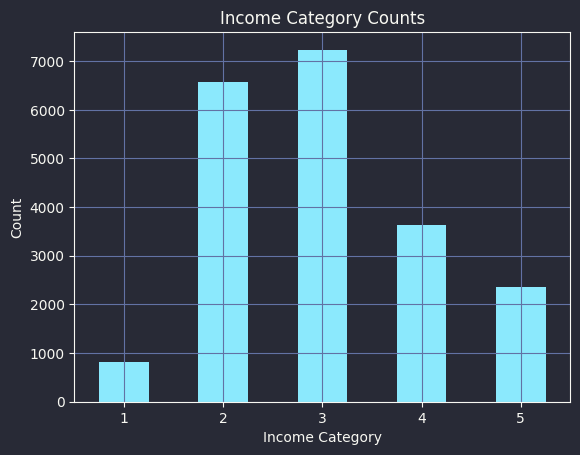

In [8]:
# create a new column for median_income categories with labels 1-5
housing_df['income_cat'] = pd.cut(housing_df['median_income'],
                                    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                    labels=[1, 2, 3, 4, 5])

# plot the value counts for the new column
housing_df['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.title('Income Category Counts')
plt.show()

In [9]:
# Split the data into training and test sets with stratified sampling on the income category
train_set, test_set = train_test_split(housing_df, test_size=0.2, random_state=42, stratify=housing_df['income_cat'])

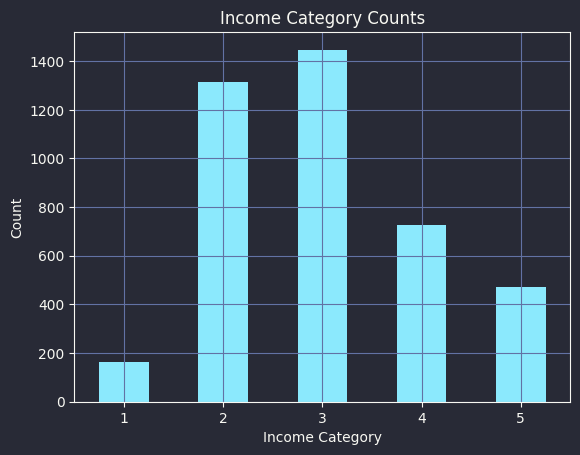

In [10]:
# let's see how the income category is distributed in the test set
test_set['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.title('Income Category Counts')
plt.show()

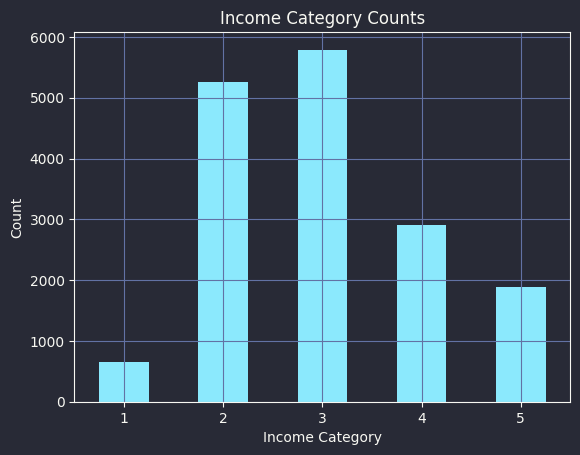

In [11]:
# let's see how the income category is distributed in the training set
train_set['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.title('Income Category Counts')
plt.show()

The distribution of train and test set look very close which is exactly what we were looking for with the stratified split.

Moving forward, let's copy the training set as we may do a number of transformations to it before working on our features. After which we will continue working with the data.

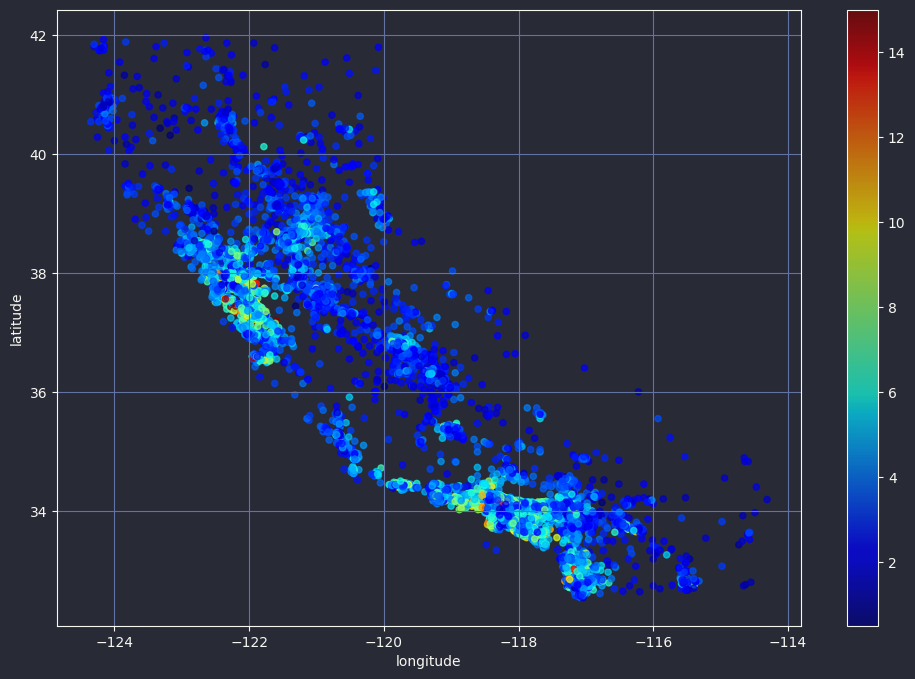

In [20]:
# copy the training set to a new dataframe
housing_train_df = train_set.copy()

# plot the latitude and longitude of the training set
train_set.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.7, c=train_set['median_income'], figsize=(12,8), cmap=plt.get_cmap('jet'))
plt.show()

# yes it looks like california, and a weather map - it was a bit of fun to mess around with the alpha and cmap parameters